In [1]:
import os
from os import path as osp
import shutil
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# Load data
hand = json.load(open("./hand_pose_data.txt"))
img_dir = "./images/"
imgs = os.listdir(img_dir)
print(len(hand), len(imgs))
save_path = "./data"
annotation_csv = "./filter_paper_v2.csv"

16015 7854


In [3]:
# Helpers to save synced data to disk
def get_hand_pose_from_msg(msg):
    hand_joints = [{"joint": m["joint"], "position": m["position"]}
                   for m in msg["joint_poses"]]

    # Rejecting joints not in OpenPose hand skeleton format
    reject_joint_list = ['ThumbMetacarpalJoint',
                         'IndexMetacarpal',
                         'MiddleMetacarpal',
                         'RingMetacarpal',
                         'PinkyMetacarpal']
    joint_pos = []
    for j in hand_joints:
        if j["joint"] not in reject_joint_list:
            joint_pos.append(j["position"])
    joint_pos = np.array(joint_pos).flatten()

    # Appending 1 as per H2O requirement
    if msg["hand"] == 'Right':
        rhand = np.concatenate([[1], joint_pos])
        lhand = np.zeros_like(rhand)
    elif msg["hand"] == 'Left':
        lhand = np.concatenate([[1], joint_pos])
        rhand = np.zeros_like(lhand)
    else:
        lhand = np.zeros_like(len(joint_pos)+1)
        rhand = np.zeros_like(len(joint_pos)+1)

    return lhand, rhand


def write_synced_data(mmdata, fpath):
    idx = 0
    format_str = "{:06d}"
    for fn in tqdm.tqdm(mmdata):
        src_img_name = osp.join("images", fn)
        dst_img_name = osp.join(
            fpath, "rgb", format_str.format(idx)+'.png')
        shutil.copy(src_img_name, dst_img_name)

        if len(mmdata[fn]) > 0:
            # Get the most recent hand pose info for each frame
            lhand, rhand = get_hand_pose_from_msg(mmdata[fn][-1])
        else:
            lhand = np.zeros(64)
            rhand = np.zeros(64)

        hpose_name = osp.join(fpath, "hand_pose",
                              format_str.format(idx)+'.txt')
        hpose = np.concatenate([lhand, rhand])
        np.savetxt(hpose_name, hpose, newline=" ")

        idx += 1


def create_activity_annotations(csv_name, annotations):
    csv_reader = csv.reader(open(csv_name))
    rows = [x for x in csv_reader]
    h2o_data = [["id", "path", "action_label", "start_act",
                "end_act", "start_frame", "end_frame"]]

    for i in range(2, len(rows), 2):
        idx = rows[i][0]
        path = "data/rgb/"
        action_label = annotations[rows[i][-2]]
        start_act = rows[i][2]
        end_act = rows[i+1][2]
        start_frame = '0'
        end_frame = str(len(imgs))
        h2o_data.append(
            [idx, path, action_label, start_act, end_act, start_frame, end_frame]
        )
        
    h2o_data = [' '.join(x) for x in h2o_data]
    np.savetxt('data/action_annotations.txt', np.array(
        h2o_data, dtype=object), delimiter=" ", fmt="%s")

In [5]:
# Sync the multi-streamed data
imgs = sorted(imgs)
hand_ts = [x['time_sec']+(x['time_nanosec']*1e-9) for x in hand]

print('Is hand pose data sorted? ', hand_ts == sorted(hand_ts))
slop = 1e-1    # In seconds
mm_dict = {fn: [] for fn in imgs}
i, j = 0, 0

# Each frame has multiple hand samples. The unassigned hand 
# samples are assigned to the most recent frame (if it is 
# within slop interval) We assign the most recent detected hand
# to the frame within slop parameter.
while i < len(imgs) and j < len(hand_ts):
    fnum, ts, tns = map(int, imgs[i].strip().split('.')[0].split('_')[1:])
    tsec = ts+(tns*1e-9)
    if (tsec - hand_ts[j]) < slop:
        if tsec >= hand_ts[j]:
            mm_dict[imgs[i]].append(hand[j])
            j += 1
        else:
            i += 1
    else:
        j += 1

Is hand pose data sorted?  True


7854 5489


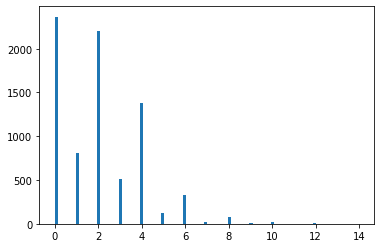

In [130]:
# Histogram of number of hand-pose samples for each frame
dlen = [len(mm_dict[x]) for x in mm_dict]
print(len(dlen), len(np.nonzero(dlen)[0]))
plt.hist(dlen, bins=100)
plt.show()

In [6]:
# Save the data to disk
write_synced_data(mm_dict, save_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7854/7854 [01:15<00:00, 104.07it/s]


In [152]:
# Create activity class annotations
annotations = ["background",
               "place the dripper on top of the mug",
               "take the coffee filter and fold it in half to create a semi-circle",
               "Fold the filter in half again to create a quarter-circle",
               "place the folded filter into the dripper such that the point of the quarter-circle rests in the center of the dripper",
               "spread the filter open to create a cone inside the dripper"]
annotations = {annotations[i]: str(i) for i in range(len(annotations))}
create_activity_annotations(annotation_csv, annotations)

['id path action_label start_act end_act start_frame end_frame', '0 data/images/ 1 329 421 0 7854', '1 data/images/ 2 491 816 0 7854', '2 data/images/ 3 842 981 0 7854', '3 data/images/ 4 1021 1076 0 7854', '4 data/images/ 5 1098 1212 0 7854', '5 data/images/ 1 2153 2288 0 7854', '6 data/images/ 2 2310 2446 0 7854', '7 data/images/ 3 2452 2596 0 7854', '8 data/images/ 4 2640 2768 0 7854', '9 data/images/ 5 2775 2889 0 7854', '10 data/images/ 1 3310 3390 0 7854', '11 data/images/ 2 3415 3584 0 7854', '12 data/images/ 3 3593 3829 0 7854', '13 data/images/ 4 3892 4002 0 7854', '14 data/images/ 5 4013 4298 0 7854', '15 data/images/ 1 4946 5016 0 7854', '16 data/images/ 2 5093 5342 0 7854', '17 data/images/ 3 5517 5671 0 7854', '18 data/images/ 5 5697 5843 0 7854', '19 data/images/ 0 6572 6747 0 7854', '20 data/images/ 1 6810 6865 0 7854', '21 data/images/ 2 6927 7051 0 7854', '22 data/images/ 3 7077 7212 0 7854', '23 data/images/ 4 7264 7355 0 7854', '24 data/images/ 5 7381 7549 0 7854']
